# Laboratory 3 – BB84 Protocol Simulation in Qiskit

## Dmytro Romaniv  
### Student ID: 151958

---

In this laboratory we implement and simulate the **BB84 quantum key distribution (QKD) protocol** using Qiskit.

The goals are:
1. Implement a *prepare-and-measure* BB84 scheme in the style presented on the lecture slides.
2. Use the quantum circuit as a **random number generator** for Alice and Bob.
3. Perform **key sifting** and study how the length of the sifted key depends on the number of transmitted bits.
4. Present the results in a report-friendly format (tables, circuit diagram).


## 1. Brief overview of the BB84 protocol

The BB84 protocol (Bennett & Brassard, 1984) is a **prepare-and-measure** QKD scheme.

- Alice encodes classical bits using single photons in two possible bases:
  - **Computational (Z) basis**: $|0\rangle, |1\rangle$
  - **Hadamard (X) basis**: $|+\rangle, |-\rangle$, where $|+\rangle = (|0\rangle + |1\rangle)/\sqrt{2}$ and $|-\rangle = (|0\rangle - |1\rangle)/\sqrt{2}$.
- For each bit, Alice chooses a random bit $x_A \in \{0,1\}$ and a random basis $y_A \in \{Z, X\}$. Bob chooses a random basis $y_B$ and obtains a bit $x_B$ by measuring.
- Afterwards they publish only the bases $y_A, y_B$ and **keep** positions where $y_A = y_B$ (key sifting).
- In an ideal/noiseless setting without eavesdropping, the resulting keys are identical.

We encode one BB84 round on 4 qubits:
- `q0` – data photon,
- `q1` – Alice's random bit $x_A$,
- `q2` – Alice's random basis $y_A$,
- `q3` – Bob's random basis $y_B$.


In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import Aer
from qiskit.compiler import transpile

import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
def build_circuit_bb84():
    """
    Build one BB84 round circuit:
      - q1: random bit x_A (H, then measure into c1)
      - q2: random basis y_A (H, then measure into c2)
      - Encode onto q0 via CX (bit) and CH (basis)
      - q3: random basis y_B (H, measure into c3)
      - Bob decodes with CH controlled by q3, then measures x_B into c0

    Classical order:
      c0 <- x_B, c1 <- x_A, c2 <- y_A, c3 <- y_B
    Bitstring from get_counts has the form 'yB yA xA xB'.
    """
    q = QuantumRegister(4, "q")
    c = ClassicalRegister(4, "c")
    qc = QuantumCircuit(q, c, name="BB84")

    # Init |0000>
    qc.reset([q[0], q[1], q[2], q[3]])

    # Alice randomness
    qc.h(q[1]); qc.measure(q[1], c[1])   # x_A
    qc.h(q[2]); qc.measure(q[2], c[2])   # y_A
    qc.barrier(q)

    # Alice encoding
    qc.cx(q[1], q[0])                    # encode x_A
    qc.ch(q[2], q[0])                    # encode y_A
    qc.barrier(q)

    # Bob randomness
    qc.h(q[3]); qc.measure(q[3], c[3])   # y_B
    qc.barrier(q)

    # Bob decoding + measurement
    qc.ch(q[3], q[0])
    qc.measure(q[0], c[0])               # x_B
    qc.barrier(q)

    return qc

backend = Aer.get_backend("qasm_simulator")
bb84 = build_circuit_bb84()

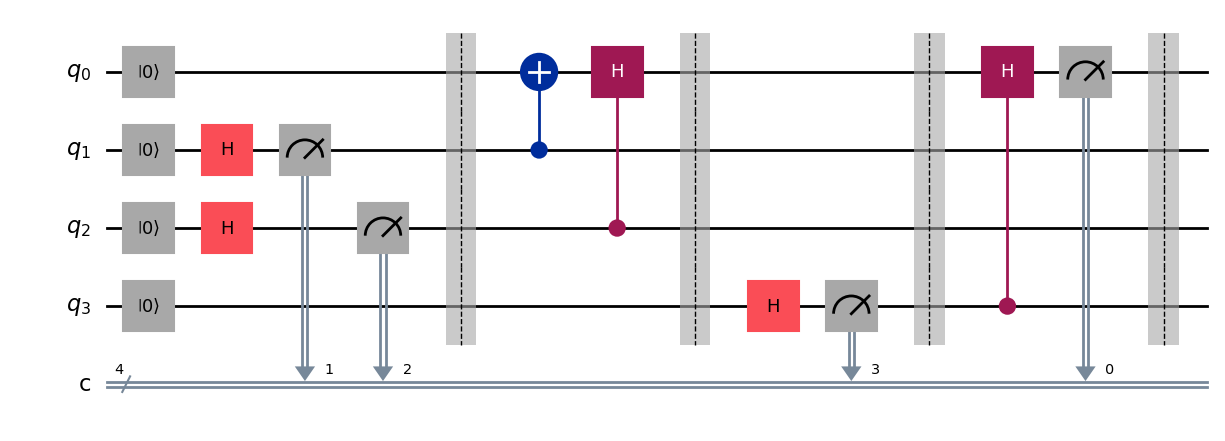

In [3]:
# Visualize the circuit for the report
fig = bb84.draw(output="mpl")
plt.tight_layout(); plt.show()

## 2. Simulation strategy

We use the circuit as a **random bit/basis generator**:
1. Execute the circuit many times (shots=1 each) to produce strings `'yB yA xA xB'`.
2. Parse them into `[x_A, y_A, y_B, x_B]`.
3. **Sift** by keeping only positions where `y_A == y_B`.


In [4]:
def parse_counts(counts):
    """Convert {'yB yA xA xB': 1} -> [xA, yA, yB, xB]. Assumes shots=1."""
    k = next(iter(counts.keys()))
    return [int(k[2]), int(k[1]), int(k[0]), int(k[3])]

def run_bits(circ, be, n_exec: int, shots: int = 1, *, opt_level: int = 0):
    """Run `circ` n_exec times and collect [xA, yA, yB, xB] reusing a compiled circuit for speed."""
    compiled = transpile(circ, be, optimization_level=opt_level)
    out = []
    for _ in range(n_exec):
        res = be.run(compiled, shots=shots).result().get_counts(circ)
        out.append(parse_counts(res))
    return out

def sift(quads):
    """Keep entries with yA == yB. Return (length, keyA, keyB)."""
    A, B = [], []
    for xA, yA, yB, xB in quads:
        if yA == yB:
            A.append(xA); B.append(xB)
    return len(A), A, B

In [5]:
# Single run demo
single = backend.run(transpile(bb84, backend), shots=1).result().get_counts(bb84)
print("Single run result (format {'yB yA xA xB': 1}):\n", single)
print("Parsed -> [xA, yA, yB, xB] =", parse_counts(single))

Single run result (format {'yB yA xA xB': 1}):
 {'0011': 1}
Parsed -> [xA, yA, yB, xB] = [1, 0, 0, 1]


In [6]:
# Small 10-sample illustration
demo_bits = run_bits(bb84, backend, n_exec=10, shots=1)
print("Generating 10 raw results:")
for b in demo_bits:
    print("[xA, yA, yB, xB] =", b)
print("\nAll bits:", demo_bits)

L, Akey, Bkey = sift(demo_bits)
print("\nKey sifting (yA == yB):")
for xA, yA, yB, xB in demo_bits:
    if yA == yB:
        print(f"yA={yA}, yB={yB} -> xA={xA}, xB={xB}")
print("kluczA =", Akey)
print("kluczB =", Bkey)
print("kluczA == kluczB?", Akey == Bkey)

Generating 10 raw results:
[xA, yA, yB, xB] = [0, 1, 1, 0]
[xA, yA, yB, xB] = [1, 0, 0, 1]
[xA, yA, yB, xB] = [0, 0, 1, 1]
[xA, yA, yB, xB] = [1, 1, 0, 1]
[xA, yA, yB, xB] = [1, 0, 0, 1]
[xA, yA, yB, xB] = [0, 1, 1, 0]
[xA, yA, yB, xB] = [0, 0, 1, 1]
[xA, yA, yB, xB] = [1, 1, 0, 0]
[xA, yA, yB, xB] = [0, 1, 1, 0]
[xA, yA, yB, xB] = [0, 1, 1, 0]

All bits: [[0, 1, 1, 0], [1, 0, 0, 1], [0, 0, 1, 1], [1, 1, 0, 1], [1, 0, 0, 1], [0, 1, 1, 0], [0, 0, 1, 1], [1, 1, 0, 0], [0, 1, 1, 0], [0, 1, 1, 0]]

Key sifting (yA == yB):
yA=1, yB=1 -> xA=0, xB=0
yA=0, yB=0 -> xA=1, xB=1
yA=0, yB=0 -> xA=1, xB=1
yA=1, yB=1 -> xA=0, xB=0
yA=1, yB=1 -> xA=0, xB=0
yA=1, yB=1 -> xA=0, xB=0
kluczA = [0, 1, 1, 0, 0, 0]
kluczB = [0, 1, 1, 0, 0, 0]
kluczA == kluczB? True


## 3. Sifted key length vs number of transmitted bits

In ideal BB84 without noise: $\Pr[y_A=y_B]=\tfrac12$, so for $n$ transmissions we expect a sifted key of length $\approx n/2$ (with binomial fluctuations).

In [7]:
samples = [16, 32, 64, 128, 256]
tests, shots = 3, 1

rows = []
for n in samples:
    row = [n]
    for _ in range(tests):
        bits_n = run_bits(bb84, backend, n_exec=n, shots=shots)
        L, Akey, Bkey = sift(bits_n)
        assert Akey == Bkey, "In ideal simulator Alice/Bob keys should match"
        row.append(L)
    rows.append(row)

df = pd.DataFrame(rows, columns=["Sample = n", "Test 1", "Test 2", "Test 3"])
print("Final table: length of sifted key vs n")
print(df.to_string(index=False))
df

Final table: length of sifted key vs n
 Sample = n  Test 1  Test 2  Test 3
         16      10       4       9
         32      20      18      17
         64      29      40      38
        128      60      64      62
        256     126     130     127


,Sample = n,Test 1,Test 2,Test 3
0,16,10,4,9
1,32,20,18,17
2,64,29,40,38
3,128,60,64,62
4,256,126,130,127


## 4. Conclusions

- The sifted key length clusters near $n/2$ as expected since bases match with probability $1/2$.
- In the simulator (no noise/eavesdropper), Alice and Bob's sifted keys coincide (QBER~0%).
- Fluctuations diminish in relative size as $n$ grows, matching binomial behavior.